In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image
import shutil as sh
import keras
from keras import layers
from keras.optimizers import Adam
from keras import ops
import datetime
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
import math
import albumentations as A
print("done importing")

2024-07-10 08:37:11.064415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 08:37:11.064515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 08:37:11.185773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


done importing


In [2]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/data-for-pneumothorax/all_data',
                                                   batch_size=16,
                                                   image_size=(224, 224))

Found 13158 files belonging to 2 classes.


In [4]:
print(data)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [5]:
total_batches = tf.data.experimental.cardinality(data).numpy()
print("Total number of batches:", total_batches)
 

Total number of batches: 823


Images shape: (16, 224, 224, 3)
Labels shape: (16,)


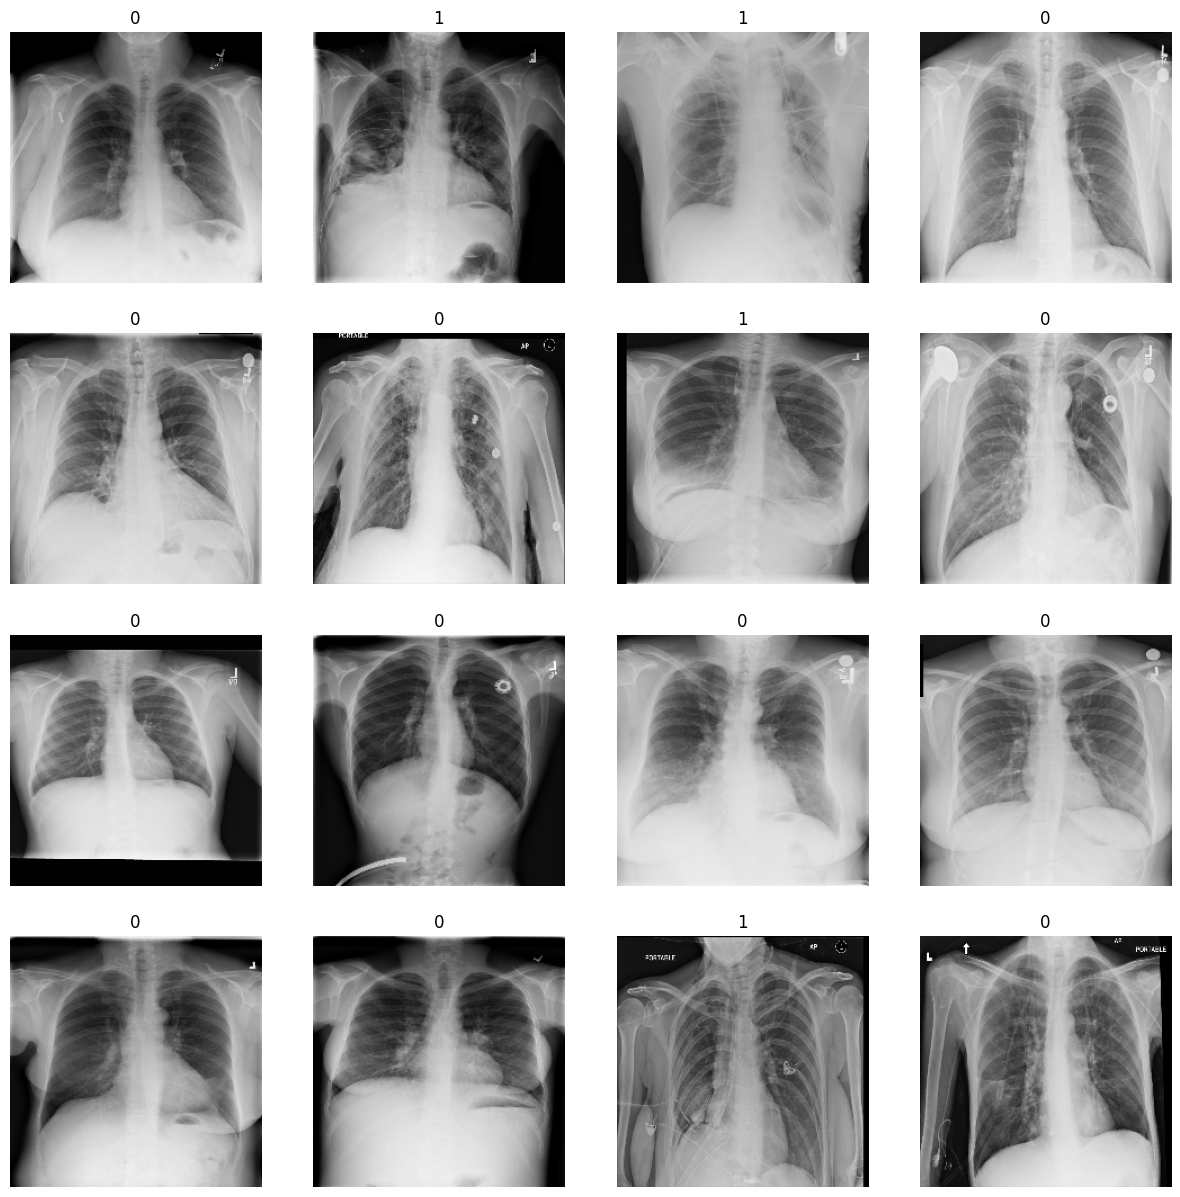

In [6]:
for images, labels in data.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    
    # Calculate the grid size
    batch_size = images.shape[0]
    grid_size = int(batch_size ** 0.5)
    grid_size = grid_size if grid_size * grid_size == batch_size else grid_size + 1

    # Display all images in the batch
    plt.figure(figsize=(15, 15))
    for i in range(batch_size):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    plt.show()


In [7]:
data_iterator = data.as_numpy_iterator()

In [8]:
data_iterator

Images shape: (16, 224, 224, 3)
Labels shape: (16,)


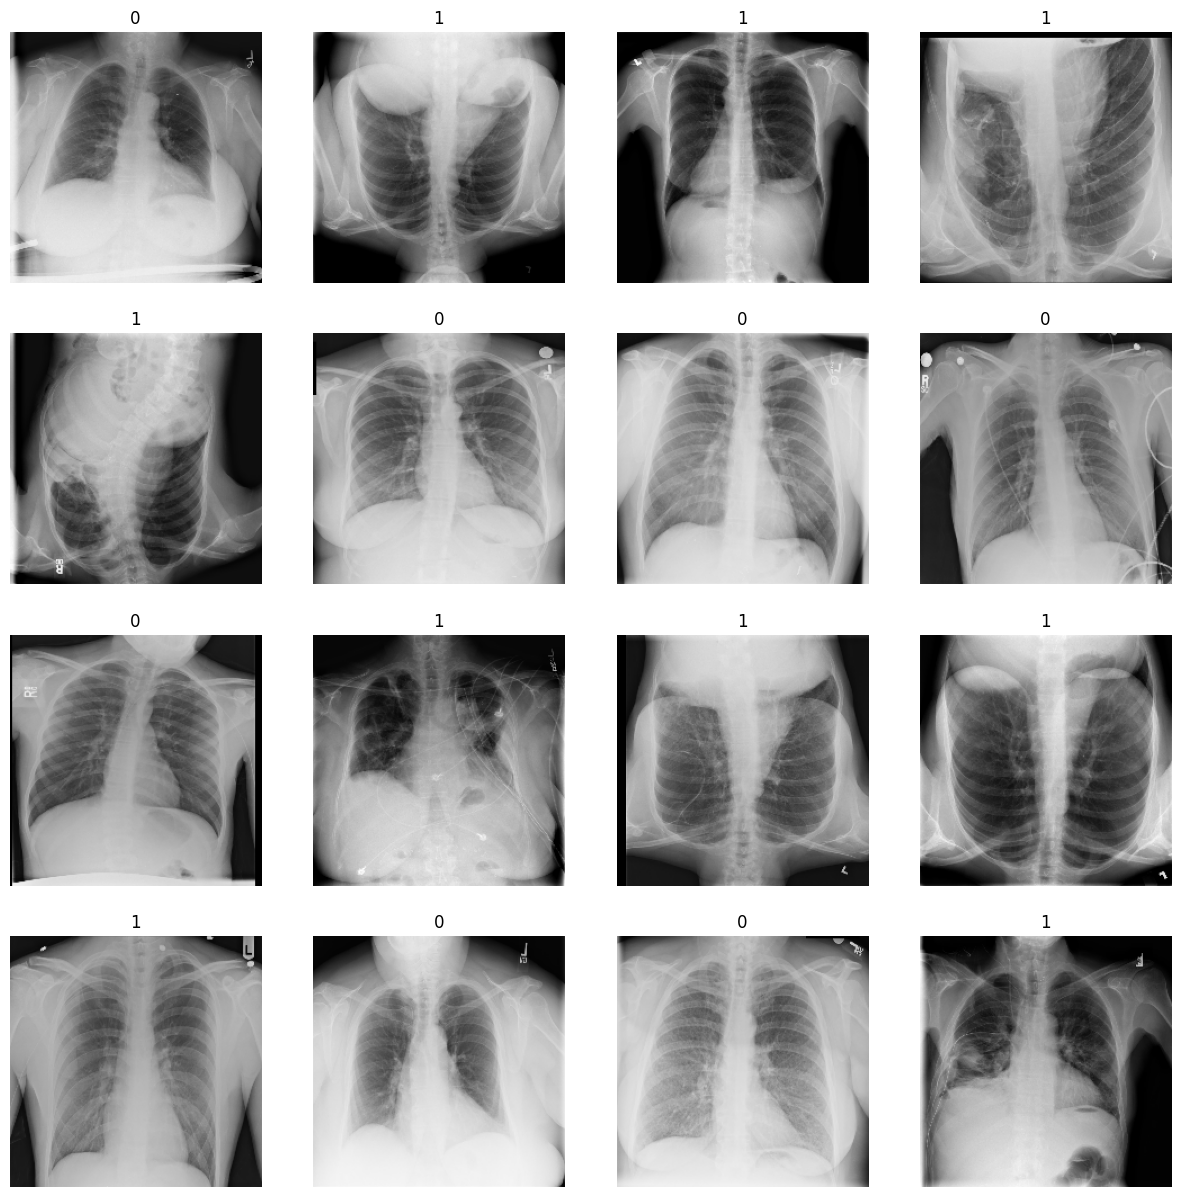

In [9]:
images, labels = next(data_iterator)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Display all images in the batch
plt.figure(figsize=(15, 15))
for i in range(images.shape[0]):
    ax = plt.subplot(4, 4, i + 1)  # Assuming batch_size is 16, so 4x4 grid
    plt.imshow(images[i].astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")
plt.show()


In [10]:
batch = data_iterator.next()

In [11]:
images, labels = batch

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: (16, 224, 224, 3)
Labels shape: (16,)


In [12]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.2)

In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [14]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)


In [15]:
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [16]:

from keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from keras.callbacks import LearningRateScheduler
from keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization


def create_chexnet(input_size=(224,224)):
    """
    chexnet_weights: weights value in .h5 format of chexnet
    creates a chexnet model with preloaded weights present in chexnet_weights file
    """
    model = tf.keras.applications.DenseNet121(include_top=False,input_shape = input_size+(3,), weights=None) #importing densenet the last layer will be a relu activation layer

    #we need to load the weights so setting the architecture of the model as same as the one of the chexnet
    x = model.output #output from chexnet
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

    chexnet = tf.keras.Model(inputs = model.input,outputs = x)
#     chexnet.load_weights(chexnet_weights)
#     chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.output)  #we will be taking the 3rd last layer (here it is layer before global avgpooling)
    #since we are using attention here
    return chexnet

In [17]:
model = create_chexnet()
model.compile(optimizer=Adam(),loss = 'binary_crossentropy',metrics=['accuracy'])

In [18]:
hist = model.fit(
    train,
    epochs=15,
    validation_data=val,
    callbacks=callbacks_list
)

Epoch 1/15


I0000 00:00:1720600915.409373     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


576/576 ━━━━━━━━━━━━━━━━━━━━ 318s 291ms/step - accuracy: 0.6818 - loss: 0.5845 - val_accuracy: 0.4931 - val_loss: 1.5002 - learning_rate: 0.0010
Epoch 2/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 159s 274ms/step - accuracy: 0.7441 - loss: 0.5063 - val_accuracy: 0.7157 - val_loss: 0.5687 - learning_rate: 0.0010
Epoch 3/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 159s 274ms/step - accuracy: 0.8030 - loss: 0.4219 - val_accuracy: 0.6883 - val_loss: 0.7847 - learning_rate: 5.0000e-04
Epoch 4/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 158s 274ms/step - accuracy: 0.8267 - loss: 0.3914 - val_accuracy: 0.5366 - val_loss: 1.2279 - learning_rate: 5.0000e-04
Epoch 5/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 159s 274ms/step - accuracy: 0.8332 - loss: 0.3680 - val_accuracy: 0.5907 - val_loss: 1.2578 - learning_rate: 5.0000e-04
Epoch 6/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 159s 274ms/step - accuracy: 0.8510 - loss: 0.3395 - val_accuracy: 0.5046 - val_loss: 2.6236 - learning_rate: 2.5000e-04
Epoch 7/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 159s 274ms/step - a

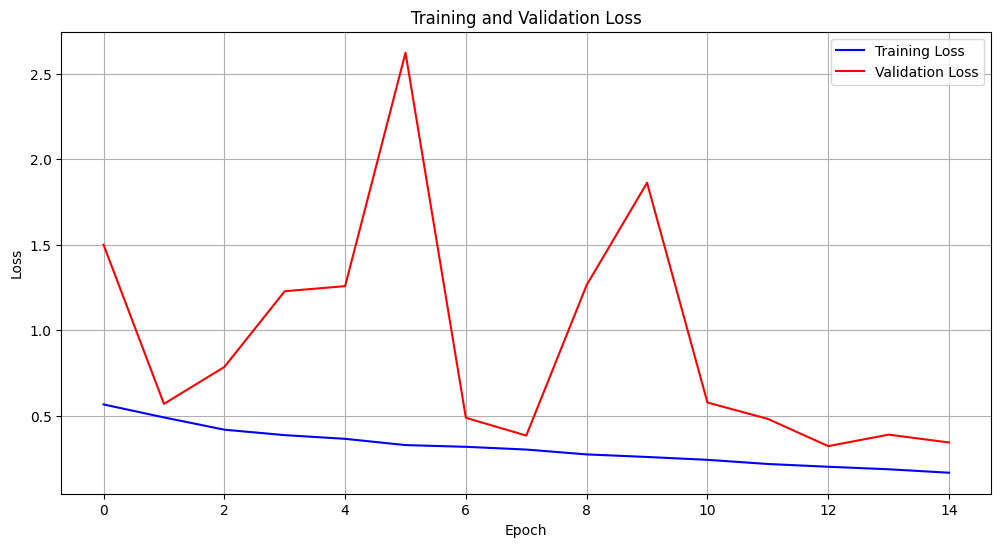

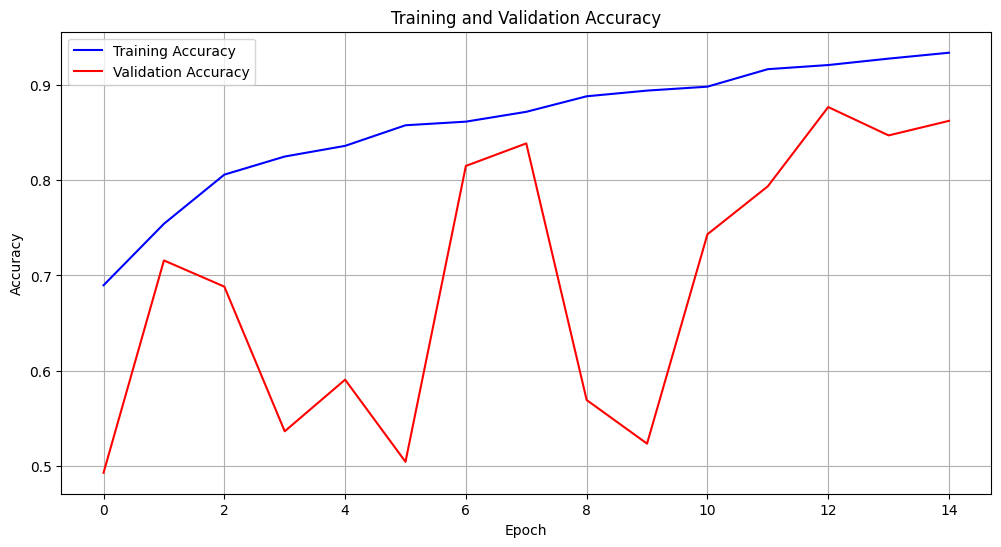

In [19]:
import matplotlib.pyplot as plt
# Extracting training history
train_loss = hist.history['loss']
train_acc = hist.history['accuracy']
val_loss = hist.history['val_loss']
val_acc = hist.history['val_accuracy']
# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Initialize counters for correct and wrong predictions
correct_predictions = 0
wrong_predictions = 0
# Set the range of indices
start_index = 0
end_index = len(test)
test_iterator = test.as_numpy_iterator()
c_o = 0
c_l = 0
for image, ground_truth_label in test_iterator:
    # Make prediction on the batch of images
    predicted_probs = model.predict(image)
    # Convert predicted probabilities to binary predictions
    predicted_labels = (predicted_probs > 0.5).astype(int)
    # Compare predicted labels with ground truth labels
    for i in range(len(ground_truth_label)):
        if predicted_labels[i][0] == ground_truth_label[i]:
            correct_predictions += 1
            if predicted_labels[i][0] == 0:
                c_o += 1
            if predicted_labels[i][0] == 1:
                c_l += 1
        else:
            wrong_predictions += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [21]:
# Display the counts of correct and wrong predictions
print("Correct Predictions:", correct_predictions)
print("Wrong Predictions:", wrong_predictions)
print("Predicted True Negatives 0:", c_o)
print("predicted True Positives 1:", c_l)

Correct Predictions: 2219
Wrong Predictions: 405
Predicted True Negatives 0: 1118
predicted True Positives 1: 1101


In [22]:
2226/(2226+398)

0.8483231707317073

In [23]:
model.save("accumodelpp84.h5")